## **Predicting Patient Hospital Readmission on GCP**
Curated by **pepecura** <br>
In this demo, you will use a **diabetics patient** data for **hospital readmission prediction**. You will start with the analysis of readmissions and creating new features, then run machine learning models with **BigQuery ML** and **AutoML Tables** and evaluate the performance in **Looker**. Finally we will run the ML model on a dataset and export the predictions into BigQuery to take actions. <br>
The public data used in the exercise will be downloaded from the [Kaggle website](https://www.kaggle.com/friedrichschneider/diabetic-dataset-for-readmission). This will require you to sign in to Kaggle. 
Find the descriptions of the variables [here](https://www.kaggle.com/iabhishekofficial/prediction-on-hospital-readmission).<br>
 <br> 

**Prerequisite:**
This lab is tested on [AI Platform Notebooks](https://cloud.google.com/ai-platform-notebooks). Please [create a new notebook instance](https://cloud.google.com/ai-platform/notebooks/docs/create-new) with "Python 3", then download this code (File > Download .ipynb) and then upload to the notebook instance.

## **Load Data**
After you download the patients data from Kaggle to your local drive, go to AI Platform Notebooks. Select "Upload Files" on the top left menu and follow the next steps.

In [ ]:
!ls "/home/jupyter"

In [ ]:
!unzip "diabetic_data.csv.zip" -d data/

In [ ]:
#check the project id.
PROJECT    = !gcloud config get-value project
PROJECT_ID = PROJECT[0]
print(PROJECT_ID)

**Load data from local to BigQuery tables**

In [ ]:
#create a dataset called "hcls" in BigQuery and load the data into that dataset.
!bq --location=eu mk --dataset hcls  
!bq load --autodetect --source_format=CSV --max_bad_records=100000 hcls.diabetic_data /home/jupyter/data/diabetic_data.csv

**Load bigquery extension for calling cell magic to run a query and display the result as a DataFrame**

In [ ]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## **Prepare Data in BigQuery**
There are multiple visits of the same patients and in order to avoid the bias in the data we will select the first visit of each patient and also create new variables based on their recent medication usage. <br>
The query called by bigquery magic will return the results in a dataframe and it will be stored in the handler that is used after %%bigquery (eg. df).

In [ ]:
%%bigquery df --verbose 
#select first visit of patients, drop redundant variables and create new features.
SELECT * EXCEPT (weight,payer_code,medical_specialty,admission_type_id,admission_source_id,
                    tolazamide,acetohexamide,miglitol,examide,citoglipton,glipizide_metformin,glimepiride_pioglitazone,
                    metformin_rosiglitazone,metformin_pioglitazone,tolbutamide,troglitazone,firstvisit),
         (metmorfin_up + glimepiride_up + glipizide_up + glyburide_up + pioglitazone_up + insulin_up) as med_up_cnt,
         (metmorfin_down + glimepiride_down + glipizide_down + glyburide_down + pioglitazone_down + insulin_down) as med_down_cnt
    FROM
      (SELECT * ,
            row_number() over(partition by patient_nbr order by encounter_id) as firstvisit,
            if(metformin="Up", 1, 0) as metmorfin_up,
            if(glimepiride="Up", 1, 0) as glimepiride_up,
            if(glipizide="Up", 1, 0) as glipizide_up,
            if(glyburide="Up", 1, 0) as glyburide_up,
            if(pioglitazone="Up", 1, 0) as pioglitazone_up,
            if(insulin="Up", 1, 0) as insulin_up,
            if(metformin="Down", 1, 0) as metmorfin_down,
            if(glimepiride="Down", 1, 0) as glimepiride_down,
            if(glipizide="Down", 1, 0) as glipizide_down,
            if(glyburide="Down", 1, 0) as glyburide_down,
            if(pioglitazone="Down", 1, 0) as pioglitazone_down,
            if(insulin="Down", 1, 0) as insulin_down,  
        FROM `hcls.diabetic_data`)
WHERE firstvisit=1

Executing query with job ID: 0eb94bd2-5b46-4a9e-8fde-52fe6a26334d
Query executing: 0.38s
Query complete after 0.56s


In [ ]:
df.shape

In [ ]:
#recode target in data frame using replace function in pandas package in python.
df['readmitted_flag'] = df['readmitted'].replace('>30', 0)
df['readmitted_flag'] = df['readmitted_flag'].replace('<30', 1)
df['readmitted_flag'] = df['readmitted_flag'].replace('NO', 0)

In [ ]:
#remove the hospital discharge reasons such as "move to a better hospital".
df_data = df[df['discharge_disposition_id'].isin([1,6,8,9,13])].copy()
df_data.shape

In [ ]:
#check the distribution of events in the data- very rare (3%) in this dataset.
df_data['readmitted_flag'].value_counts()

0    49033
1     1434
Name: readmitted_flag, dtype: int64

In [ ]:
#create new features.
df_data['number_visits'] = df_data['number_outpatient'] + df_data['number_emergency'] + df_data['number_inpatient']

#recode medication changes to convert into binary variables (change/no change:1/0).
vars = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 
        'glyburide', 'pioglitazone','rosiglitazone', 'acarbose','insulin', 'glyburide_metformin']
   
for col in vars:
    col_yes = str(col) + '_yes'
    col_ch = str(col) + '_ch'
    df_data[col_yes] = df_data[col].apply(lambda x: 0 if (x == 'No') else 1)
    df_data[col_ch]  = df_data[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
    
#create a new variable that counts number of medical changes.
df_data['med_yes_cnt'] = 0
df_data['med_change_cnt'] = 0
for col in vars:
    col_yes = str(col) + '_yes'
    col_ch = str(col) + '_ch'
    df_data['med_yes_cnt'] = df_data['med_yes_cnt'] + df_data[col_yes]
    df_data['med_change_cnt'] = df_data['med_change_cnt'] + df_data[col_ch]

In [ ]:
#recode some variables and make them binary.
df_data['change'] = df_data['change'].replace('Ch', 1)
df_data['change'] = df_data['change'].replace('No', 0)
df_data['gender'] = df_data['gender'].replace('Male', 1)
df_data['gender'] = df_data['gender'].replace('Female', 0)
df_data['diabetesMed'] = df_data['diabetesMed'].replace('Yes', 1)
df_data['diabetesMed'] = df_data['diabetesMed'].replace('No', 0)
df_data['A1Cresult'] = df_data['A1Cresult'].replace('>7', 1)
df_data['A1Cresult'] = df_data['A1Cresult'].replace('>8', 1)
df_data['A1Cresult'] = df_data['A1Cresult'].replace('Norm', 0)
df_data['A1Cresult'] = df_data['A1Cresult'].replace('None', -99)
df_data['max_glu_serum'] = df_data['max_glu_serum'].replace('>200', 1)
df_data['max_glu_serum'] = df_data['max_glu_serum'].replace('>300', 1)
df_data['max_glu_serum'] = df_data['max_glu_serum'].replace('Norm', 0)
df_data['max_glu_serum'] = df_data['max_glu_serum'].replace('None', -99)

In [ ]:
#recode age variable.
for i in range(0,10):
    df_data['age'] = df_data['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)

#convert age categories to mid-point values
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df_data['age'] = df_data.age.map(age_dict)

In [ ]:
# correlation analysis.
import seaborn as sns
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())

table = df_data[['readmitted_flag', 'time_in_hospital', 'diabetesMed', 'change', 'med_yes_cnt', 'med_change_cnt','med_up_cnt','med_down_cnt']].corr(method='pearson')
table.style.background_gradient(cmap=my_cmap, axis = 0)

,readmitted_flag,time_in_hospital,diabetesMed,change,med_yes_cnt,med_change_cnt,med_up_cnt,med_down_cnt
readmitted_flag,1.000000,0.049027,0.042718,0.007429,0.023886,0.006280,0.081561,-0.049919
time_in_hospital,0.049027,1.000000,0.072994,0.121037,0.081747,0.108877,0.127301,0.030855
diabetesMed,0.042718,0.072994,1.000000,0.410044,0.507936,0.161944,0.132886,0.091378
change,0.007429,0.121037,0.410044,1.000000,0.646870,0.412762,0.327109,0.242035
med_yes_cnt,0.023886,0.081747,0.507936,0.646870,1.000000,0.380168,0.212449,0.283295
med_change_cnt,0.006280,0.108877,0.161944,0.412762,0.380168,1.000000,0.514096,0.788341
med_up_cnt,0.081561,0.127301,0.132886,0.327109,0.212449,0.514096,1.000000,-0.104662
med_down_cnt,-0.049919,0.030855,0.091378,0.242035,0.283295,0.788341,-0.104662,1.000000


In [ ]:
#install pandas bigquery module to write dataframes into BigQuery tables.
!pip install --quiet pandas-gbq

In [ ]:
df_data.to_gbq('hcls.diabetic_data_model', project_id= str(PROJECT_ID), if_exists='replace')

1it [00:08,  8.63s/it]


## **Explore your Data in Looker**
Create a Looker account and connect to your BigQuery table to [explore the data in Looker](https://docs.looker.com/exploring-data) and create some dashboards to understand the data better before moving into the modelling stage.


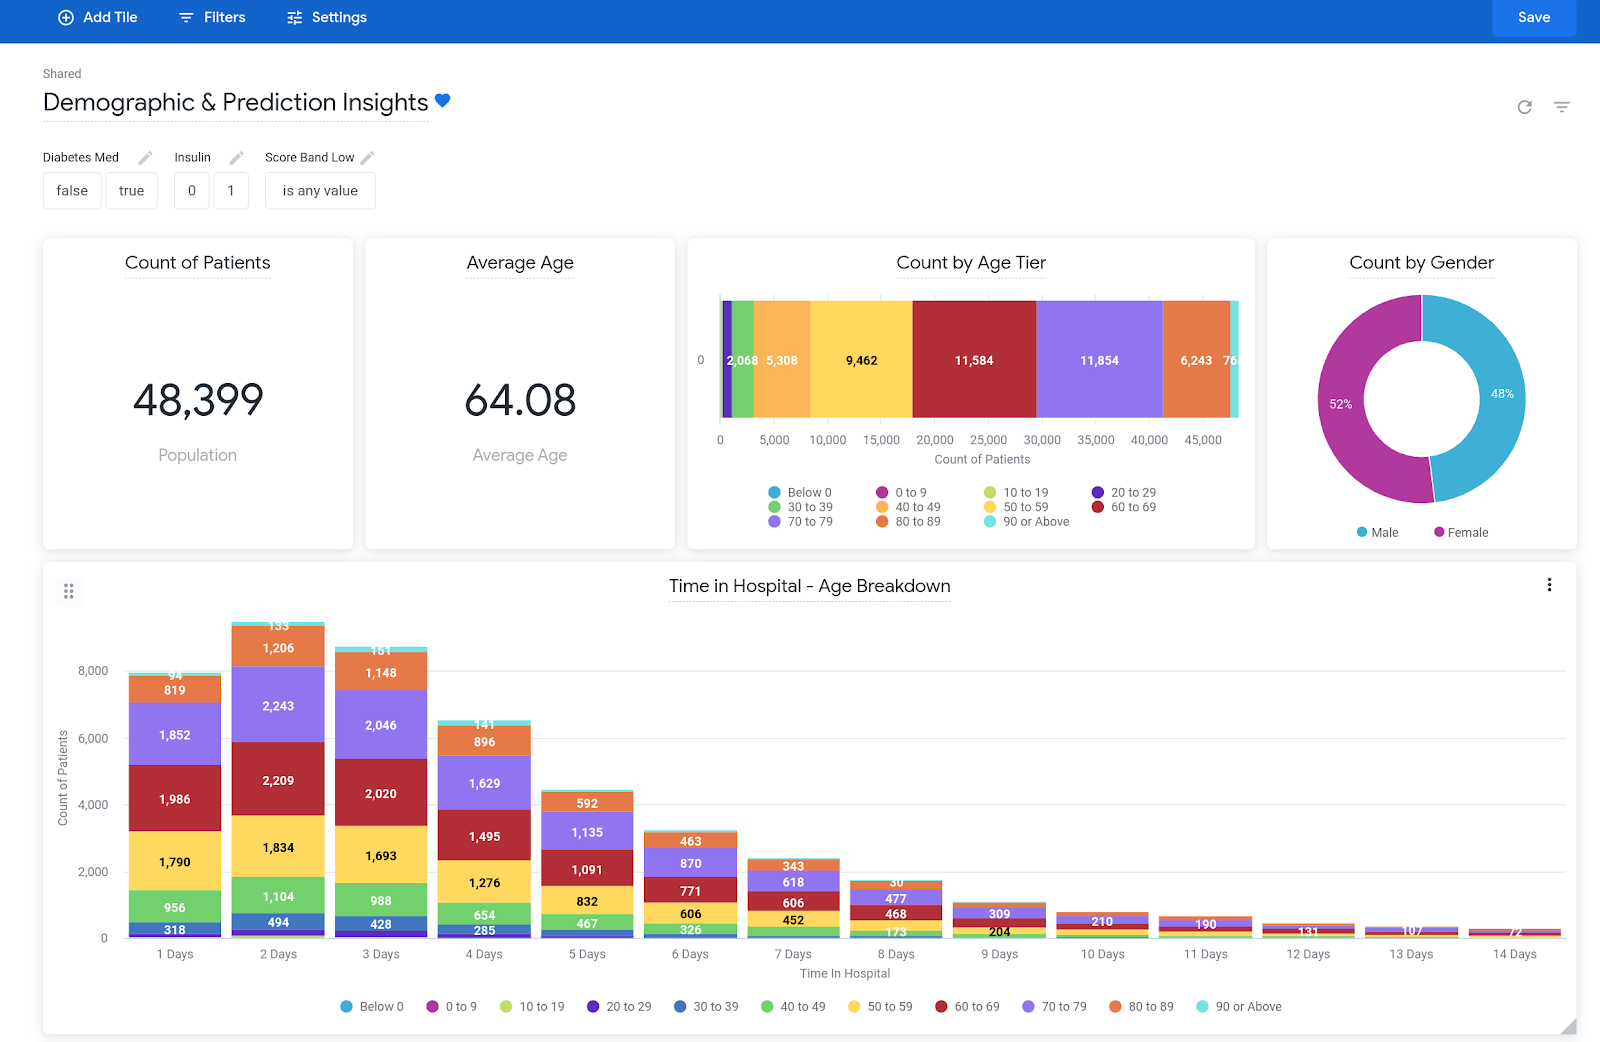

## **Build ML Models with BigQuery**
https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create

In [ ]:
%%bigquery --verbose
#create the baseline model with regression.
CREATE OR REPLACE MODEL `hcls.model_patient_reg`
 OPTIONS(MODEL_TYPE='LOGISTIC_REG',INPUT_LABEL_COLS = ["readmitted_flag"], SUBSAMPLE=0.8) 
AS SELECT
  * EXCEPT (readmitted, encounter_id, gender, race, patient_nbr, diag_1, diag_2, diag_3, discharge_disposition_id)
FROM `hcls.diabetic_data_model`

Executing query with job ID: f5840e6d-bf79-44c6-92f9-7871560729e6
Query executing: 72.76s
Query complete after 73.45s


""


In [ ]:
%%bigquery
SELECT * 
FROM ML.EVALUATE(MODEL hcls.model_patient_reg)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.4,0.007299,0.972406,0.014337,0.10627,0.792449


In [ ]:
%%bigquery --verbose
#create a new model with boosted tree.
CREATE OR REPLACE MODEL `hcls.model_patient_boostedtree`
 OPTIONS(MODEL_TYPE='BOOSTED_TREE_CLASSIFIER',INPUT_LABEL_COLS = ["readmitted_flag"], SUBSAMPLE=0.8) 
AS SELECT
  * EXCEPT (readmitted, encounter_id, gender, race, patient_nbr, diag_1, diag_2, diag_3, discharge_disposition_id)
FROM `hcls.diabetic_data_model`

Executing query with job ID: 3ce860e3-e053-43b5-85e5-3623166222ec
Query executing: 454.29s
Query complete after 454.95s


""


In [ ]:
%%bigquery
SELECT * 
FROM ML.EVALUATE(MODEL hcls.model_patient_boostedtree)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.890625,0.208029,0.977524,0.337278,0.09365,0.83625


## **Deploy Model**
The [ROC](https://colab.research.google.com/drive/1VZKA4YK6YwpG7-XLkkz1YSl6-EaT0YxL#scrollTo=HxvqpuerxyqE&line=2&uniqifier=1)-AUC value (area under the curve) for the Boosted Tree is higher than the Regression model. This is one of the metrics that helps us to choose the best model. To keep it simple for the demo, we go ahead and choose the boosted tree model to deploy.  You could also assess the results for [Lift](https://en.wikipedia.org/wiki/Lift_(data_mining)), [Precision/Recall](https://en.wikipedia.org/wiki/Precision_and_recall), misclassification rate etc. by applying different cut-off thresholds for the readmission decision. 

In [ ]:
%%bigquery predictions_readmission --verbose
#predict the likelihood of patients on a new data (for demo purposes, we will use the training data, since the data is limited).
SELECT encounter_id, patient_nbr, readmitted_flag, p.prob as score
FROM
  ML.PREDICT(MODEL `hcls.model_patient_boostedtree`, 
  (SELECT * FROM
  `hcls.diabetic_data_model` 
  )
)
, unnest( predicted_readmitted_flag_probs) as p
where p.label = 1 
order by p.prob desc

Executing query with job ID: 016640b0-a97c-4b38-bd3c-caedc51756a2
Query executing: 0.67s
Query complete after 0.91s


In [ ]:
#select the subset of patients with high probability scores and check the actual distribution. 
predictions_readmission[predictions_readmission.score >.2]['readmitted_flag'].value_counts()

1    464
0    143
Name: readmitted_flag, dtype: int64

In [ ]:
#save the scores back into BigQuery to take actions. 
predictions_readmission.to_gbq('hcls.predictions_readmission', project_id= str(PROJECT_ID), if_exists='replace')

1it [00:02,  2.83s/it]


## **Visualise Predictions in Looker**
Read the prediction results from BigQuery table in Looker and explore the distributions of probability scores. 
* In the overall population, 2.92% of diabetes patients are readmitted in less than 30 days.
* Band-1 includes the diabetic patients that have the highest probability score based on the AutoML model.
* 62.8% of patients in Band-1 are readmitted to the hospital within less than 30 days, which is 21 times higher than the overall rate. 

The patients in the top band, has the highest probability scores. Majority of them will be readmitted to the hospital in less than 30 days. **Their discharge decision should be reevaluated and assessed in more detail based on these predictions.**





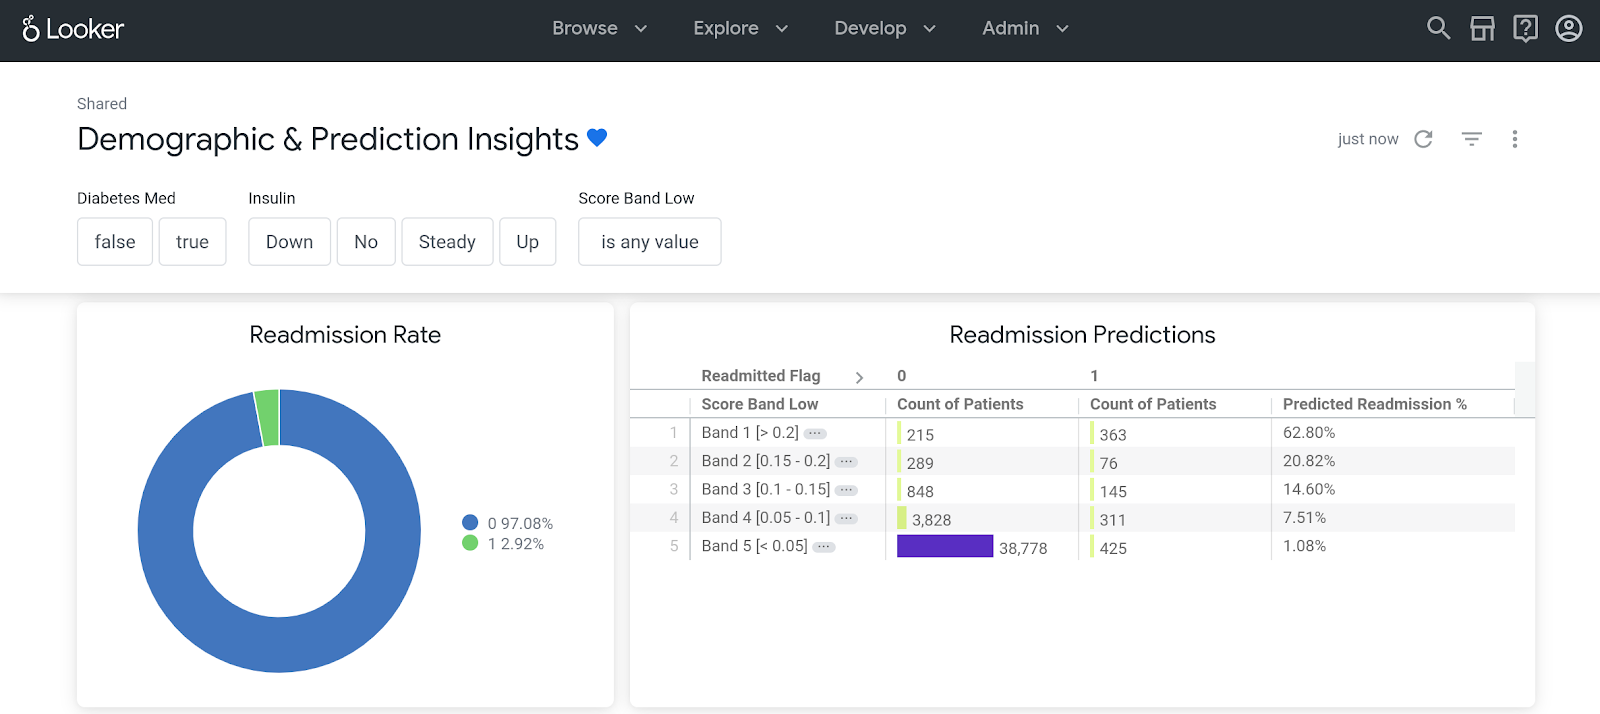

## **Next Step: Build Model with AutoML**
As a next step, you may use the same data to build an AutoML model. <br>
To build the AutoML model using the GUI, go to AI Platform (unified) and select "Datasets". Then select Tabular data, upload the training data from BigQuery and follow the steps in the GUI to start the training. Once the training is completed go to Evaluate and see the performance of the AutoML model. <br>
You may also call AutoML classifier model from BigQuery ML as shown below. The deep learning algorithms running behind the scenes in AutoML require large amount of data for better predictions. With small data, dont expect to get the best results with AutoML.


In [ ]:
%%bigquery --verbose
CREATE OR REPLACE MODEL `hcls.model_patient_automl`
#create a model with automl.
 OPTIONS(MODEL_TYPE='AUTOML_CLASSIFIER', BUDGET_HOURS = 1, INPUT_LABEL_COLS = ["readmitted_flag"]) 
AS SELECT
  * EXCEPT (readmitted, encounter_id, gender, race, patient_nbr, diag_1, diag_2, diag_3, discharge_disposition_id)
FROM `hcls.diabetic_data_model`

<font color='green'> **End of file.** </font>